![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRjFm003pSAOtHmnUm7e--Xquwo90Hp5-U_3wSZrkChGz4tQYWZ)
# Introduction to Machine Learning
##Lab 5: Support Vector Machines

It this lab we will be implementing some parts of SVM algorithm.


Refer to [these lecture notes](http://cs229.stanford.edu/notes/cs229-notes3.pdf) for better understanding SVM and navigating through the code.

In [0]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint, BFGS
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs, make_moons

Let's define two types of kernels: <br>
Linear:
$K(x, z)=x^{T} z$
<br>
and Poynomial:
$K(x, z)=\left(x^{T} z+c\right)^{3}$ <br>
Pay attention that these formulas are for two vectors, and we need to define kernel functions for x and z which are matrices (*n_samples X n_features*). So, as an output we want to return a matrix (*n_samples X n_samples*) where each value is a kernel applied to a pair of observations of x and z.

In [0]:
def linear_kernel(x, z):
    """
    linear kernel <x,z>
    returns scalar - output of the kernel
    x, z - vectors / matrices
    """
    ### START CODE HERE ###
    return np.dot(x, z.T)
    ### END CODE HERE ###


def polynomial_kernel(x, z):
    """
    polynomial kernel (<x,z> + c)^3 with degree = 3 and c=1
    returns scalar - output of the kernel
    x, z - vectors / ndarrays
    """
    ### END CODE HERE ###
    dot_product = np.dot(x, z.T)
    dot_product = (dot_product + 1) ** 3
    return dot_product
    ### END CODE HERE ###

In [0]:
def test_linear_kernel():
    a = np.array([1,2,3])
    aa = np.array([1,2,3,4,5,6]).reshape(-1,2)
    aa_result = np.array([[ 5, 11, 17],
                           [11, 25, 39],
                           [17, 39, 61]])
    if linear_kernel(a,a) == 14 and np.array_equal(linear_kernel(aa,aa), aa_result):
        print("Linear kernel test passed")
    else:
        print("Linear kernel test failed")

test_linear_kernel()

Linear kernel test passed


In [0]:
def test_poly_kernel():
    a = np.array([1,2,3])
    aa = np.array([1,2,3,4,5,6]).reshape(-1,2)
    aa_result = np.array([[216, 1728, 5832],
                          [1728, 17576, 64000],
                          [5832, 64000, 238328]])    
    if polynomial_kernel(a,a) == 3375 and np.array_equal(polynomial_kernel(aa,aa), aa_result):
        print("Polynomial kernel test passed")
    else:
        print("Polynomial kernel test failed")

test_poly_kernel()

Polynomial kernel test passed


This is the function we want to optimize, together with constraints:

$
\begin{array}{ll}{\max _{\alpha}} & {W(\alpha)=\sum_{i=1}^{m} \alpha_{i}-\frac{1}{2} \sum_{i, j=1}^{m} y^{(i)} y^{(j)} \alpha_{i} \alpha_{j}\left\langle x^{(i)}, x^{(j)}\right\rangle} \\ {\text { s.t. }} & {\alpha_{i} \geq 0, \quad i=1, \ldots, m} \\ {} & {\sum_{i=1}^{m} \alpha_{i} y^{(i)}=0}\end{array}$

Implement the above function. Note that we are using the optimizer which **minimizes** the function, so you need to account for this.

In [0]:
def function_to_optimize(alphas, y, x, kernel):
    """
    write here the function you are going to optimize
    note that we are using the optimizer which minimizes the function, so you need to account for this
    returns value of the function calculated based on parameters
    inputs:
    alphas - 1D array
    y - labels, 1D array
    x - data of shape(n_samples, n_features)
    kernel - callable, defines kernel function to use
    """
    ### START CODE HERE ###
    alphas = alphas.reshape(len(alphas), 1)
    y = y.reshape(len(y), 1)
    y_n = np.dot(y, y.T)
    alphas_n = np.dot(alphas, alphas.T)
    x_n = kernel(x, x)
    func = np.sum(alphas) - 0.5 * np.sum(y_n * alphas_n * x_n)
    return -func
    ### END CODE HERE ###

In [0]:
def test_optimize():
    alphas_t = np.array([1,2,3])
    y_t = np.array([4,5,6])
    x_t = np.array([1,2,3,4,5,6]).reshape(-1,2)
    if function_to_optimize(alphas_t,y_t, x_t, linear_kernel) == 19850.0:
        print("Optimize test passed")
    else:
        print("Optimize test failed")

test_optimize()

Optimize test passed


Now, if alphas are found, we can calculate w and b:

$w=\sum_{i=1}^{m} \alpha_{i} y^{(i)} x^{(i)}$
<br><br>
Next, SVM assumes:<br>
$w x+b=0$<br>
$w x_{s p}+b=1~~~(x_{s p} \text { is a support vector with } y=1) $ <br>
$w x_{s n}+b=-1 \quad\left(x_{s n} \text { is a support vector with } y=-1)\right.$


Hence, $b=1-w x_{s p},$

In [0]:
def find_support_vector_inds(alphas, thresh):
    """
    returns array of indices of all support vectors, i.e. those for which alpha > 0
    instead of zero we are using some threshold to account for roundoff errors
    alphas - array of solutions
    thresh - threshold
    """
    return np.where(alphas > thresh)[0]


def find_w_b(alphas, y, x, sv_inds, kernel, thresh, C):
    """
    calculates w and b after alphas are found. w is calculated only if we are using linear kernel
    w is a vector, b is a scalar
    for calculating b, recall that if x_pos is a positive support vector (with y=1), 
    then w*x_pos+b=1, hence b = 1 - w*x_pos      
    x_pos is a positive support vectors => lying *exactly* on the margin
    Recall that if sample is on correct side, then alpha = 0, if it's exactly on the margin, then 0 < alpha < C,
    if it's on wrong side, alpha = C. So, chose any of those for which 0 < alpha < C, accounting for roundoff errors (!)
    inputs:
    alphas - array of solutions, 1D array
    y - labels, 1D array
    x - data of shape(n_samples, n_features)
    sv_inds - indices of support vectors
    kernel - callable, defines kernel function to use
    thresh - threshold
    C - constant
    """
    w = None    
    ### START CODE HERE ###
    # find w if it's a linear case
    if kernel == linear_kernel:
        w = np.zeros(x[0, :].shape)
        for i in sv_inds:
            w += alphas[i] * y[i] * x[i, :]
    # find b. first find index of any positive support vector
    pos_sv_ind = ((y == 1) & (alphas > thresh) & (alphas < (C - 1))).nonzero()[0][0]    
    # calculate w*x_pos
    w_pos = 0
    for i in sv_inds:
        w_pos += alphas[i] * y[i] * (kernel(x[i, :], x[pos_sv_ind, :]))    
    # calculate b    
    b = 1 - w_pos
    ### END CODE HERE ###
    return w, b


Finally, we are able to make our predictions: 

$\begin{aligned} w^{T} x+b &=\left(\sum_{i=1}^{m} \alpha_{i} y^{(i)} x^{(i)}\right)^{T} x+b \\ &=\sum_{i=1}^{m} \alpha_{i} y^{(i)}\left\langle x^{(i)}, x\right\rangle+ b \end{aligned}$

In [0]:
def predict(alphas, y, x, x_test, b, sv_inds, kernel):
    """
    make predictions for x_test
    returns array of predictions (1 or -1)
    alphas - array of solutions, 1D array
    y - labels, 1D array
    x - data of shape(n_samples, n_features)
    x_test - data for which predictions should be made
    b - calculated b
    sv_inds - indices of support vectors
    kernel - callable, defines kernel function to use
    """    
    predictions = np.zeros(shape=(len(x_test),))
    ### START CODE HERE ###
    for j, sample in enumerate(x_test):
        pred = b
        for i in sv_inds:
            pred += alphas[i] * y[i] * (kernel(x[i, :], sample))
        predictions[j] = 1 if pred > 0 else -1
    ### END CODE HERE ###    
    return predictions

Starting computations...
status: 2
message: `xtol` termination condition is satisfied.
alphas of support vectors: 
 [ 5.32880861 99.99999365 38.39348819 99.99999504 33.06451688]


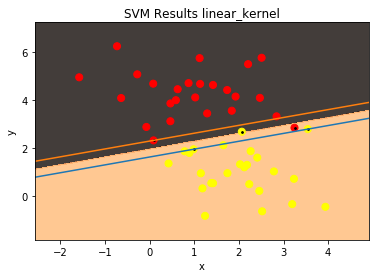

Starting computations...
status: 2
message: `xtol` termination condition is satisfied.
alphas of support vectors: 
 [0.65062548 0.25184053 1.20556264 0.8067763 ]


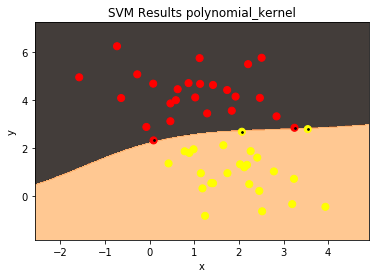

Starting computations...
status: 2
message: `xtol` termination condition is satisfied.
alphas of support vectors: 
 [99.99999943 99.999999   99.99999932 99.99999893 99.99999774 87.9148933
 68.10759794 99.99999771 99.9999994  99.999999   99.99999902 99.99999855
 99.99999657 56.02267672 99.99999742 99.9999974 ]


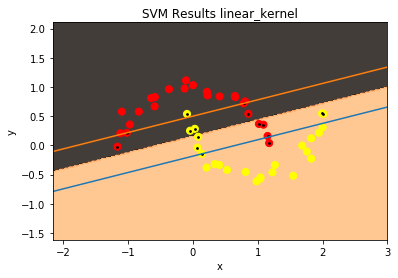

Starting computations...
status: 2
message: `xtol` termination condition is satisfied.
alphas of support vectors: 
 [4.20207494 2.01190767 2.52741171 6.16825043 1.94321603 0.62992527]


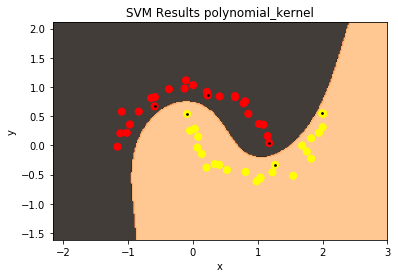

In [0]:
# this is the main function which brings it all together
# examine it to understand what's happening in each line
def minimize_and_plot(X, Y, kernel, C, thresh):
    n = len(Y)
    # arguments to pass to minimize function
    args = (Y, X, kernel)

    # define the constraints (page 20) as instances of scipy.optimize.LinearConstraint
    # constraints each alpha to be from 0 to C
    alpha_constr = LinearConstraint(np.identity(n), lb=0, ub=C)
    # constraints sum of (alpha * y)
    alpha_y_constr = LinearConstraint(Y, lb=0, ub=0)

    print("Starting computations...")
    # minimization. we are using ready QP solver 'trust-constr'
    result = minimize(fun=function_to_optimize, method='trust-constr', x0=np.empty(shape=(n,)), jac='2-point',
                      hess=BFGS(exception_strategy='skip_update'), constraints=[alpha_constr, alpha_y_constr],
                      args=args)
    # prints the results. If status==0, then the optimizer failed to find the optimal value
    print("status:", result.status)
    print("message:", result.message)

    alphas = result.x
    # indexes of support vectors
    sv_inds = find_support_vector_inds(alphas, thresh)
    print("alphas of support vectors:", '\n', alphas[sv_inds])

    w, b = find_w_b(alphas, Y, X, sv_inds, kernel, thresh, C)

    # create a mesh to plot points and predictions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xrange, yrange = np.meshgrid(np.arange(x_min, x_max, 0.02),
                                 np.arange(y_min, y_max, 0.02))
    # form a grid by taking each point point from x and y range
    grid = np.c_[xrange.ravel(), yrange.ravel()]
    grid = grid.astype(float)
    # make predictions for each point of the grid
    grid_predictions = predict(alphas, Y, X, grid, b, sv_inds, kernel)
    grid_predictions = grid_predictions.reshape(xrange.shape)

    # plot color grid points according to the prediction made for each point
    plt.contourf(xrange, yrange, grid_predictions, cmap='copper', alpha=0.8)
    # plot initial data points
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='autumn')
    # plot support vectors
    plt.scatter(X[sv_inds, 0], X[sv_inds, 1], s=3, c="black")

    if w is not None:  # print lines on which support vectors should reside
        x_plot = np.linspace(x_min, x_max - 0.02, 1000)
        y_plot_1 = (- w[0] * x_plot - b + 1) / w[1]
        y_plot_2 = (- w[0] * x_plot - b - 1) / w[1]
        plt.plot(x_plot, y_plot_1)
        plt.plot(x_plot, y_plot_2)

    plt.title('SVM Results ' + kernel.__name__)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


# here we assign values for constants
n_samples = 50
C_const = 100
threshold = 1e-3

# generating (almost) linearly separable data, replacing 0 labels with -1
X_blob, Y_blob = make_blobs(n_samples=n_samples, centers=2, random_state=0, cluster_std=1.00)
Y_blob[Y_blob == 0] = -1
# plt.scatter(X_blob[:, 0], X_blob[:, 1], c=Y_blob, s=50, cmap='autumn')
# plt.show()
minimize_and_plot(X_blob, Y_blob, linear_kernel, C_const, threshold)  # svm with linear kernel
minimize_and_plot(X_blob, Y_blob, polynomial_kernel, C_const, threshold)  # svm with polynomial kernel

# generating moon-shaped data, replacing 0 labels with -1
X_moon, Y_moon = make_moons(n_samples=n_samples, shuffle=False, noise=0.10, random_state=0)
Y_moon[Y_moon == 0] = -1
# plt.scatter(X_moon[:, 0], X_moon[:, 1], c=Y_moon, s=50, cmap='autumn')
# plt.show()
minimize_and_plot(X_moon, Y_moon, linear_kernel, C_const, threshold)  # svm with linear kernel
minimize_and_plot(X_moon, Y_moon, polynomial_kernel, C_const, threshold)  # svm with polynomial kernel
